In [ ]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

from pathlib import Path
image_path = Path('data/stanford_data/images')
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names[:3]

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x12e441b10>,
 ['affenpinscher', 'afghan_hound', 'african_hunting_dog'])

In [10]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(87))

(-0.5, 223.5, 223.5, -0.5)

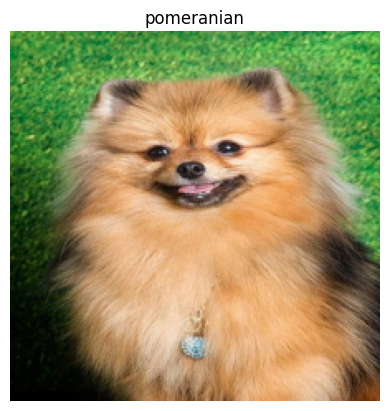

In [11]:
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [ ]:
from model.vit import ViT

vit = ViT()
summary(vit)

Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─Dropout: 1-1                                                    --
├─PatchEmbedding: 1-2                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─TransformerEncoderBlock: 2-3                               --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      2,363,904
│    │    └─MLPBlock: 3-2                                         4,723,968
│    └─TransformerEncoderBlock: 2-4                               --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      2,363,904
│    │    └─MLPBlock: 3-4                                         4,723,968
│    └─TransformerEncoderBlock: 2-5                         

In [ ]:
from going_modular.going_modular import engine
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]